<a href="https://colab.research.google.com/github/MurphLaws/Exp/blob/main/Group_Influence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt, cm, colors
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from itertools import chain
import itertools
import tensorflow as tf
from sklearn.model_selection import train_test_split
from operator import itemgetter
tf.autograph.set_verbosity(0)
from tqdm import tqdm
import os
from matplotlib.ticker import FixedFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import bisplrep, bisplev
from scipy.ndimage import gaussian_filter
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from itertools import compress
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.lines import Line2D
from scipy.spatial import KDTree
from more_itertools import flatten


,X1,X2,Label
0,-0.001461,-0.657357,0.0
1,0.480067,-2.240576,0.0
2,-0.048678,-0.573525,0.0
3,1.519183,-1.040114,0.0
4,0.038773,1.612674,0.0


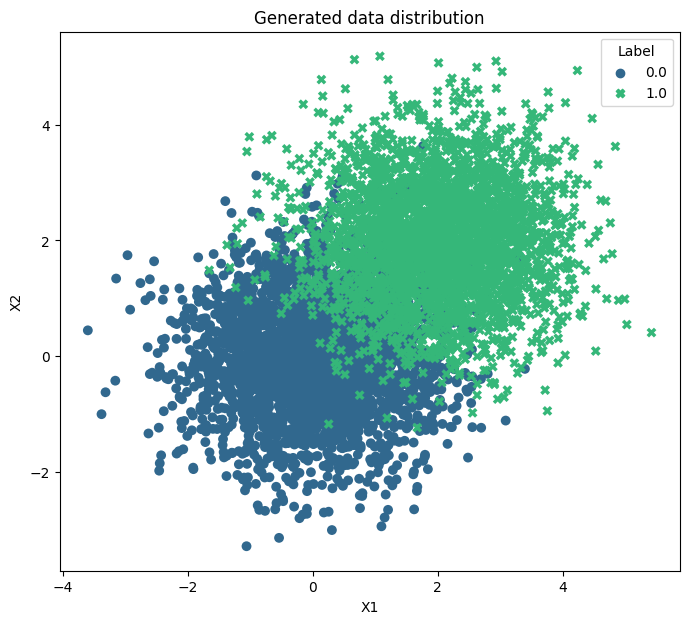

In [2]:
random.seed(2349324)
np.random.seed(2349324)
tf.random.set_seed(2349324)


# Create dataset composed of teo points clusters with generated with a bivariate gaussian distribution with mean [0,0] and [4,4]
# and equal covariance matrices.

def create_data(n):
    mean1 = [0,0]
    covmat = [[1, 0], [0, 1]]
    cov  = covmat
    x1_1, x2_1 = np.random.multivariate_normal(mean1, cov, int(n/2)).T

    mean2 = [2,2]
    cov  = covmat
    x1_2, x2_2 = np.random.multivariate_normal(mean2, cov, int(n/2)).T

    pts1 = list(zip(x1_1, x2_1,itertools.repeat(0)))
    pts2 = list(zip(x1_2, x2_2,itertools.repeat(1)))

    return pd.DataFrame(np.concatenate((pts1,pts2),axis=0), columns = ["X1", "X2", "Label"])


interleaved  = create_data(6000)


plt.figure(figsize=(8,7))
sns.scatterplot(data=interleaved, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=50, linewidth=0).set(title = 'Generated data distribution')
interleaved.head()

In [3]:
Data = namedtuple('Data', ['x_train','x_test','y_train','y_test'])



def binary_cross_entropy(predictions, probabilities):
    binary_crossentropy = []
    for i in range(len(predictions)):
        b = predictions[i]
        p = probabilities[i][1]  # Assuming the probability of the positive class is at index 1

        # Calculate the binary crossentropy
        cross_entropy = -b * np.log(p) - (1 - b) * np.log(1 - p)
        binary_crossentropy.append(cross_entropy)

    return binary_crossentropy




def pred_and_prob(data):
    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)

    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return y_pred, y_proba



def train_predict(data):

    np.random.seed(2349324)


    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)


    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return binary_cross_entropy(list(data.y_test), y_proba)



def leave_one_out_area(df, group_list):
    datasets = []
    for group in group_list:
        datasets.append((group, df.drop(group)))
    return datasets



def area_group_matrix(train, test, criteria_array):
    influences = []
    shr_x_train = train[['X1','X2']]
    shr_y_train = train['Label']
    shr_x_test  = test[['X1','X2']]
    shr_y_test  = test['Label']


    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))

    datasets = leave_one_out_area(shr_x_train, criteria_array)

    groups = [str(loo[0]) for loo in datasets]
    str_id_data = [((str(loo[0])),loo[1]) for loo in datasets]
    inf_matrix = pd.DataFrame(0, index=groups, columns=list(shr_x_test.index))

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[str(ds[0])] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    return inf_matrix






,X1,X2,Label
1231,-1.914409,-1.951685,0.0
2113,-1.918339,-1.926355,0.0
337,-2.183586,-1.682980,0.0
2279,-2.147121,-1.641747,0.0
1776,-2.077375,-1.608166,0.0
...,...,...,...
5338,2.755220,4.163528,1.0
3449,3.059473,3.165788,1.0
3056,3.368614,2.905158,1.0
5385,2.732996,4.010636,1.0


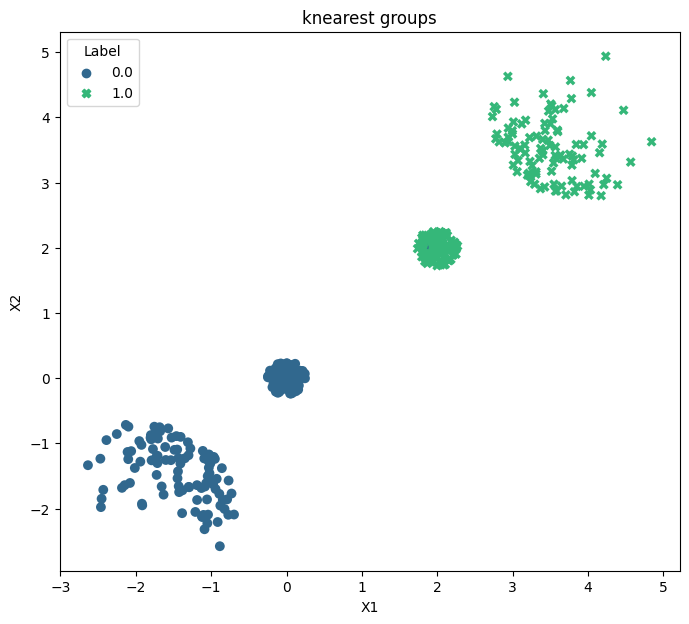

In [4]:

def get_neighbors(df, k, n_points, criteria='Random', given_centers = None):

    final = []

    if criteria == 'Random':
        random.seed(2349324)
        np.random.seed(2349324)
        center_indices  = df.sample(n=n_points).index
        points = df[['X1', 'X2']]


        points_dict = {idx: (points.loc[idx, 'X1'], points.loc[idx, 'X2']) for idx in  center_indices}
        kdtree = KDTree(points)

        for point in points_dict.keys():
            distances, indices = kdtree.query(points_dict[point], k=k)
            final.append((point, list(df.iloc[indices].index)))


    elif criteria == "Given":
        center_indices = given_centers
        points = df[['X1', 'X2']]
        kdtree = KDTree(points)

        for point in center_indices:
            distances,indices = kdtree.query(point, k=k)
            final.append((point, list(df.iloc[indices].index)))

    return final






def get_points_idx(indices,df):

    references = [x[0] for x in indices]
    points = [x[1] for x in indices]

    all = references+list(flatten(points))

    return df.loc[all].copy()


def get_points_coord(coord,df):

    center = [x[0] for x in coord]
    points = [x[1] for x in coord]

    all = flatten(points)

    return df.loc[all].copy()



ktest = get_points_coord(get_neighbors(interleaved, 100, 1,criteria='Given', given_centers = [(-2,-2),(2,2),(0,0),(4,4)]),interleaved)


plt.figure(figsize=(8,7))
sns.scatterplot(data=ktest, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=50, linewidth=0)
plt.title("knearest groups")


ktest

In [5]:

testdata = create_data(200)


train = testdata.sample(frac=0.8, random_state=1)
test = testdata.drop(train.index)




# CONJOINT_5 = area_group_matrix(train,test,[x[1] for x in get_neighbors(train, 5,1000)])
# CONJOINT_500 = area_group_matrix(train,test,[x[1] for x in get_neighbors(train, 500,1000)])






In [6]:
def run_MPI(matrix):
    new_df = matrix.mask(matrix < 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]

def run_MSPI(matrix):
    class_df = matrix.mask(matrix < 0, 0).mask(matrix > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df[['Influence']]

def run_MSNI(matrix):
    class_df = matrix.mask(matrix > 0, 0).mask(matrix < 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df[['Influence']]

def run_MNI(matrix):
    new_df = matrix.mask(matrix > 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)*-1
    return new_df[['Influence']]

def run_MAI(matrix):
    new_df = matrix.abs()
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]

def retrieve(original, result):
    return original.join(result).dropna()

def run_PIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MPI(new_df)

def run_NIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MNI(new_df)

def run_AIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MAI(new_df)

def run_SLIP(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    class_df = new_df.mask(new_df < 0, 0).mask(new_df > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return class_df[['Influence']]

def run_SLIN(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    class_df = new_df.mask(new_df < 0, 1).mask(new_df > 0, 0)
    class_df['Influence'] = class_df.sum(axis=1)
    return class_df[['Influence']]









In [7]:



def get_inf_graph(matrix):

    indexes = list(set(flatten([eval(x) for x in matrix.index])))
    df = pd.DataFrame(index=indexes, columns=['Influence'])
    for indexes in matrix.index:
         for idx in eval(indexes):
             df.loc[idx]=(matrix.loc[indexes]['Influence'])
    return df





# #plot_signal(MPI, "PIL1")
# lo = list(range(len(CONJOINT_50)))
# sd = []
# group_dict = dict(zip(lo,CONJOINT_50.index))
# result = {}
# for k,v in group_dict.items():
#     for idx in eval(v):
#         result[idx] = k


# df = pd.DataFrame.from_dict(result, orient='index', columns=['Group'])
# group_labeling = df.join(testdata).copy()

# group_labeling

In [8]:

def split(df, size = 0.2):
    x = df[['X1','X2']]
    y = df['Label']

    if size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=2349324)
        return Data(x_train = x_train,x_test=x_test,y_train = y_train,y_test=y_test)

    else:
        return Data(x_train=x, y_train=y, x_test = x_test, y_test = y_test)




def leave_one_out(df, inf_type="individual", n=1):

    loo_dfs = []
    if inf_type=='individual':
        for i in df.index:
            loo_dfs.append((i,df.drop([i])))

    if inf_type=='group':
        for i in df.index:
            datapoints_to_remove = (random.sample(list(df.index), n))
            loo_dfs.append((datapoints_to_remove,df.drop(datapoints_to_remove)))

    return loo_dfs

def influence_matrix(train,test):
    influences = []
    shr_x_train = train[['X1','X2']]
    shr_y_train = train['Label']
    shr_x_test  = test[['X1','X2']]
    shr_y_test  = test['Label']


    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
    datasets = leave_one_out(shr_x_train)
    inf_matrix = pd.DataFrame(0, index=list(shr_x_train.index), columns=list(shr_x_test.index))

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[ds[0]] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    return inf_matrix


In [9]:
INDIVIDUAL_INFLUENCE = influence_matrix(train,test)

100%|██████████| 160/160 [00:02<00:00, 65.68it/s]


In [10]:
def aggregate_ind(ind_matrix, group_matrix):
    sum_array = []
    aggregate_matrix = pd.DataFrame(0, index=group_matrix.index, columns=group_matrix.columns)
    for index in tqdm(group_matrix.index):
        sum = 0
        for indv in eval(index):
            sum+=np.array(ind_matrix.loc[indv])
        aggregate_matrix.loc[index] = sum
    return aggregate_matrix




# AGGREGATED_5 = aggregate_ind(INDIVIDUAL_INFLUENCE, CONJOINT_5)
# AGGREGATED_50 = aggregate_ind(INDIVIDUAL_INFLUENCE, CONJOINT_50)
# AGGREGATED_500 = aggregate_ind(INDIVIDUAL_INFLUENCE, CONJOINT_500)


In [11]:
# plt.figure(figsize=(20, 5))


# xmin = -0
# xmax = 2

# k500 = CONJOINT_500/AGGREGATED_500
# k500['ratio'] = k500.mean(axis=1)
# ecdfk500 = ECDF(k500['ratio'])
# dfk500 = pd.DataFrame({'x': ecdfk500.x, 'y': ecdfk500.y})
# sns.ecdfplot(data=dfk500, x='x', label='n = 500')
# plt.xlim(xmin, xmax)


# k50 = CONJOINT_50/AGGREGATED_50
# k50['ratio'] = k50.mean(axis=1)
# ecdfk50 = ECDF(k50['ratio'])
# dfk50 = pd.DataFrame({'x': ecdfk50.x, 'y': ecdfk50.y})
# sns.ecdfplot(data=dfk50, x='x', label='n = 50')
# plt.xlim(xmin, xmax)


# k5 = CONJOINT_5/AGGREGATED_5
# k5['ratio'] = k5.mean(axis=1)
# ecdfk5 = ECDF(k5['ratio'])
# dfk5 = pd.DataFrame({'x': ecdfk5.x, 'y': ecdfk5.y})
# sns.ecdfplot(data=dfk5, x='x', label='n = 5')
# plt.xlim(xmin, xmax)


# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Conjoint / Aggregation Influence Ratio ECDF')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


# plt.axvline(x=1, color='black', linestyle='--')
# plt.legend()  # Add a legend to show the labels
# plt.show()

In [12]:

# def group_influence_matrix(train,test, n):
#     influences = []
#     shr_x_train = train[['X1','X2']]
#     shr_y_train = train['Label']
#     shr_x_test  = test[['X1','X2']]
#     shr_y_test  = test['Label']

#     full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
#     datasets = leave_one_out(shr_x_train, inf_type='group', n=n)
#     groups = [str(loo[0]) for loo in datasets]

#     str_id_data = [((str(loo[0])),loo[1]) for loo in datasets]

#     inf_matrix = pd.DataFrame(0, index=groups, columns=list(shr_x_test.index))


#     for ds in tqdm(datasets):
#         data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
#         y_pred,y_proba = pred_and_prob(data)
#         influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
#         inf_matrix.loc[str(ds[0])] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

#     if inf_matrix.index.duplicated().any():
#         inf_matrix = inf_matrix[~inf_matrix.index.duplicated(keep='first')]


#     return inf_matrix


# RANDOM_CONJOINT_5 = group_influence_matrix(train,test, 5).head(1000)
# RANDOM_CONJOINT_50 = group_influence_matrix(train,test, 50).head(1000)
# RANDOM_CONJOINT_500 = group_influence_matrix(train,test, 500).head(1000)

In [13]:



# def ecdf(influence_matrix_1, influence_matrix_2):
#     assert influence_matrix_1.shape == influence_matrix_2.shape

#     # The function assumes that rows represent the train sample ids and
#     # columns the test sample ids. The correlations are computed column-wise.
#     # This is because this structure implies the many-to-one relation, i.e., many train examples (or groups)
#     # to one test example

#     corr_vals = {}
#     #p_value_threshold = 0.05

#     for col in influence_matrix_1.columns:
#         spearman_r, pval = spearmanr(
#             influence_matrix_1.loc[:, col], influence_matrix_2.loc[:, col]
#         )
#         #if pval <= p_value_threshold:
#         corr_vals[col] = spearman_r
#     print(
#         "Statistically significant in rows count:",
#         len(corr_vals) / influence_matrix_1.shape[1],
#     )
#     return ECDF(list(corr_vals.values()))


# # def plot_ecdf(ecdf_arr):
# #     data, ecdf =
# #     pass

# def plot_ecdf(ecdf_obj,title):
#     # Convert ECDF object to Pandas DataFrame
#     df = pd.DataFrame({'x': ecdf_obj.x, 'y': ecdf_obj.y})

#     # Plot ECDF using Seaborn
#     sns.ecdfplot(data=df, x='x')
#     plt.xlabel('X')
#     plt.ylabel('ECDF')
#     plt.title(title)
#     plt.grid(True)
#     plt.show()







In [14]:
# plt.figure(figsize=(15, 5))

# ##KNN GROUPING

# ecdfKNN5 = ecdf(CONJOINT_5, AGGREGATED_5)
# df_KNN5 = pd.DataFrame({'x': ecdfKNN5.x, 'y': ecdfKNN5.y})
# sns.ecdfplot(data=df_KNN5, x='x', label='Nearest Neighbour Grouping, n=5',color='blue')

# # ecdfKNN50 = ecdf(CONJOINT_50, AGGREGATED_50)
# # df_KNN50 = pd.DataFrame({'x': ecdfKNN50.x, 'y': ecdfKNN50.y})
# # sns.ecdfplot(data=df_KNN50, x='x', label='Nearest Neighbour Grouping, n=50',color='red')

# ecdfKNN500 = ecdf(CONJOINT_500, AGGREGATED_500)
# df_KNN500 = pd.DataFrame({'x': ecdfKNN500.x, 'y': ecdfKNN500.y})
# sns.ecdfplot(data=df_KNN500, x='x', label='Nearest Neighbour Grouping, n=500',color='red')


# ## RANDOM GROUPING

# ecdfR5 = ecdf(RANDOM_CONJOINT_5, aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_5))
# df_r5 = pd.DataFrame({'x': ecdfR5.x, 'y': ecdfR5.y})
# sns.ecdfplot(data=df_r5, x='x', label='Random Grouping,n = 5',linestyle="--",color='blue')

# # ecdfR50 = ecdf(RANDOM_CONJOINT_50, aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_50))
# # df_r50 = pd.DataFrame({'x': ecdfR50.x, 'y': ecdfR50.y})
# # sns.ecdfplot(data=df_r50, x='x', label='Random Grouping,n = 50',linestyle="--",color='red')

# ecdfR500 = ecdf(RANDOM_CONJOINT_500, aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_500))
# df_r500 = pd.DataFrame({'x': ecdfR500.x, 'y': ecdfR500.y})
# sns.ecdfplot(data=df_r500, x='x', label='Random Grouping,n = 500',linestyle="--",color='red')


# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Random vs KNN Grouping ECDFs')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter(['{:0.5f}'.format(x) for x in plt.gca().get_xticks()]))



# plt.legend()  # Add a legend to show the labels
# plt.show()


In [15]:
# plt.figure(figsize=(15, 5))


# xmin = 0.5
# xmax = 1.5

# k5 = CONJOINT_5/AGGREGATED_5
# k5['ratio'] = k5.mean(axis=1)
# ecdfk5 = ECDF(k5['ratio'])
# dfk5 = pd.DataFrame({'x': ecdfk5.x, 'y': ecdfk5.y})
# sns.ecdfplot(data=dfk5, x='x', label='KNN, n = 5',color='blue')
# plt.xlim(xmin, xmax)

# k500 = CONJOINT_500/AGGREGATED_500
# k500['ratio'] = k500.mean(axis=1)
# ecdfk500 = ECDF(k500['ratio'])
# dfk500 = pd.DataFrame({'x': ecdfk500.x, 'y': ecdfk500.y})
# sns.ecdfplot(data=dfk500, x='x', label='KNN, n = 500',color='red')
# plt.xlim(xmin, xmax)

# r5 = RANDOM_CONJOINT_5/aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_5)
# r5['ratio'] = r5.mean(axis=1)
# ecdfr5 = ECDF(r5['ratio'])
# dfr5 = pd.DataFrame({'x': ecdfr5.x, 'y': ecdfr5.y})
# sns.ecdfplot(data=dfr5, x='x', label='Random, n = 5',linestyle="--",color='blue')
# plt.xlim(xmin, xmax)


# r500 = RANDOM_CONJOINT_500/aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_500)
# r500['ratio'] = r500.mean(axis=1)
# ecdfr500 = ECDF(r500['ratio'])
# dfr500 = pd.DataFrame({'x': ecdfr500.x, 'y': ecdfr500.y})
# sns.ecdfplot(data=dfr500, x='x', label='Random, n = 500',linestyle="--",color='red')
# plt.xlim(xmin, xmax)


# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Conjoint / Aggregation Influence Ratio ECDF')
# plt.grid(True)

# #plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


# plt.axvline(x=1, color='black', linestyle='--')
# plt.legend()  # Add a legend to show the labels
# plt.show()

In [16]:
CONJOINT_50 = area_group_matrix(train,test,[x[1] for x in get_neighbors(train, 50,50)])



100%|██████████| 50/50 [00:00<00:00, 59.57it/s]


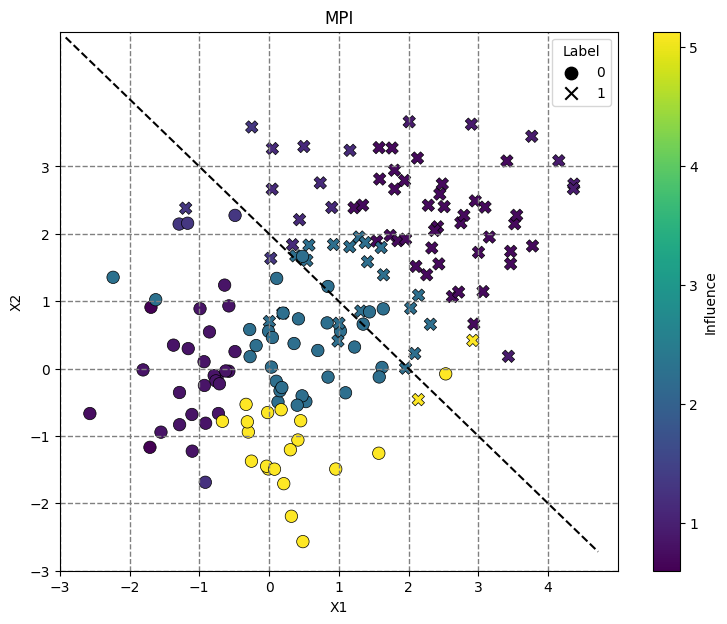

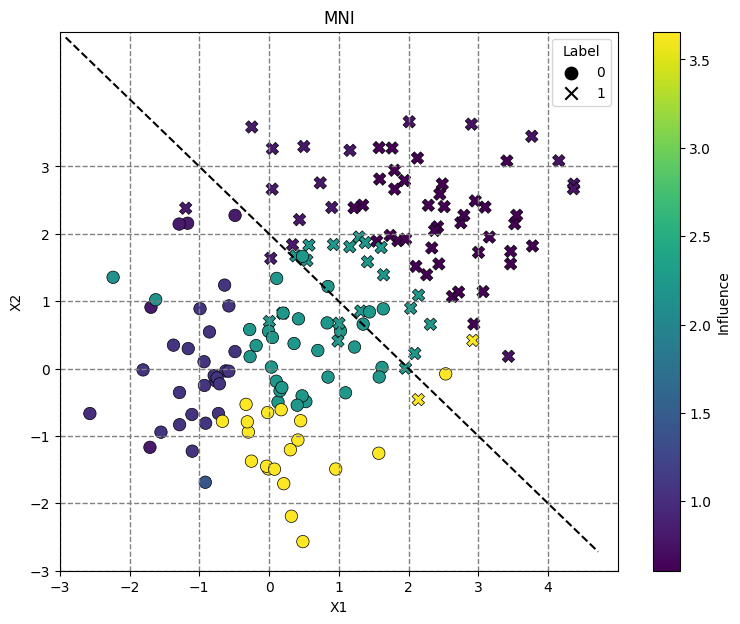

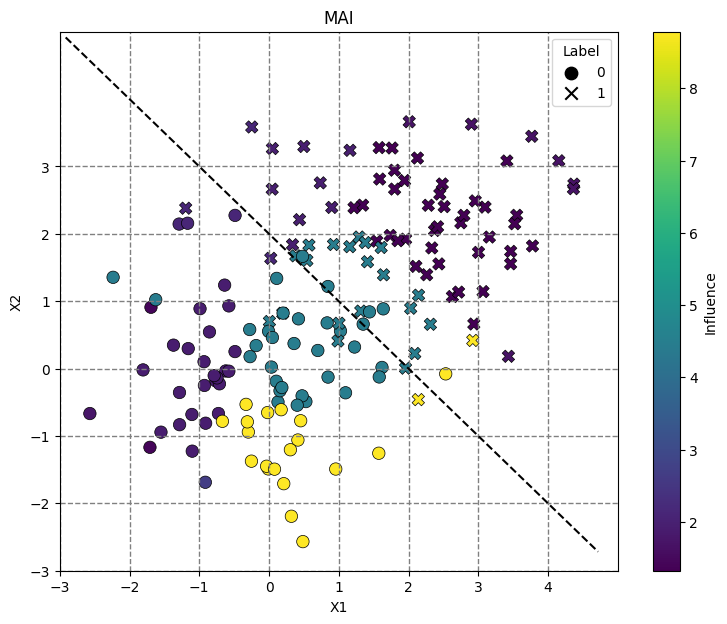

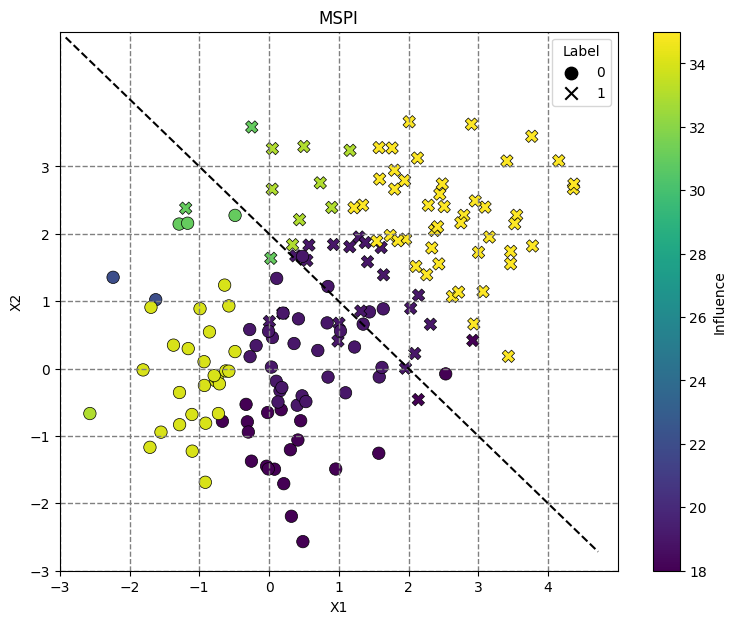

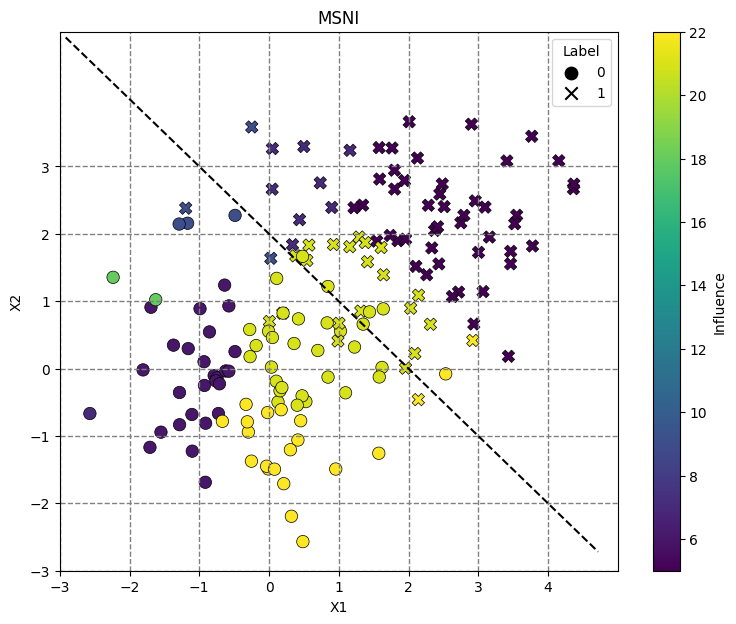

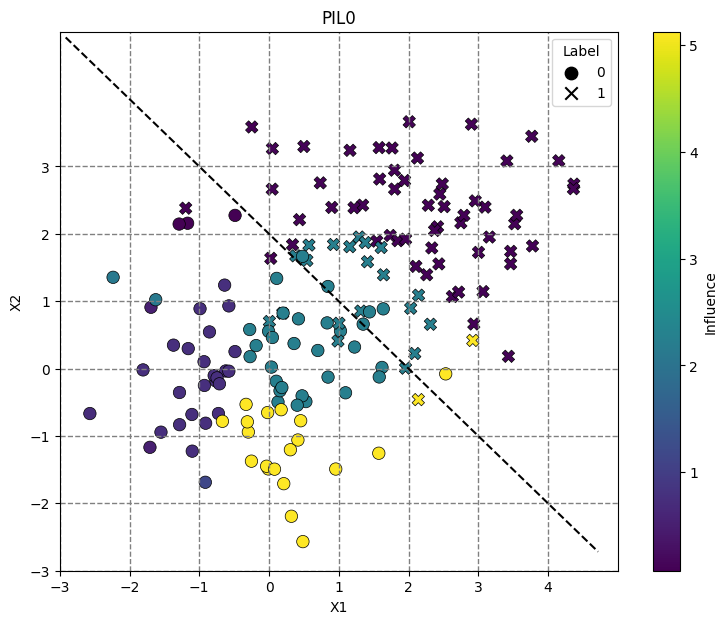

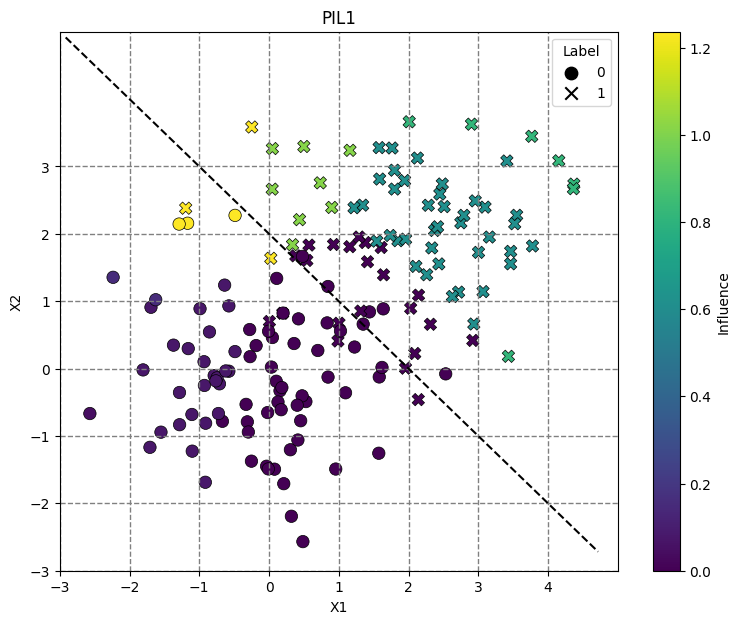

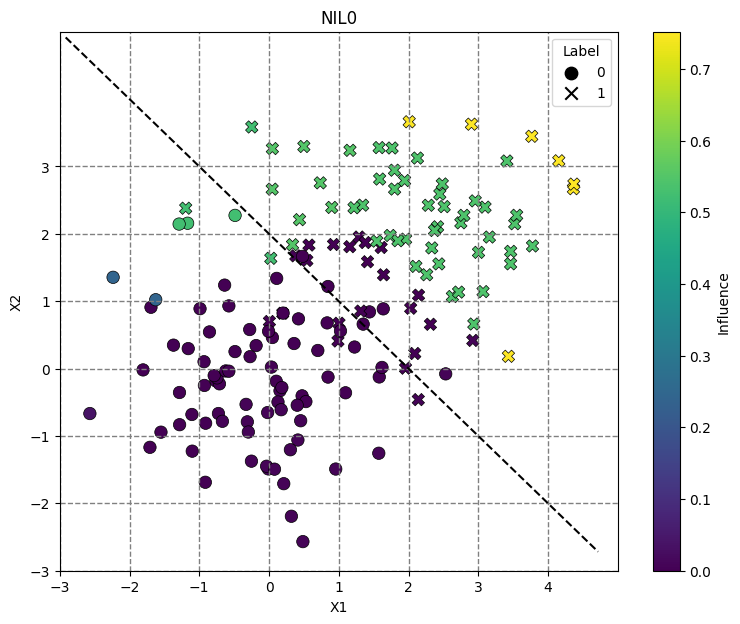

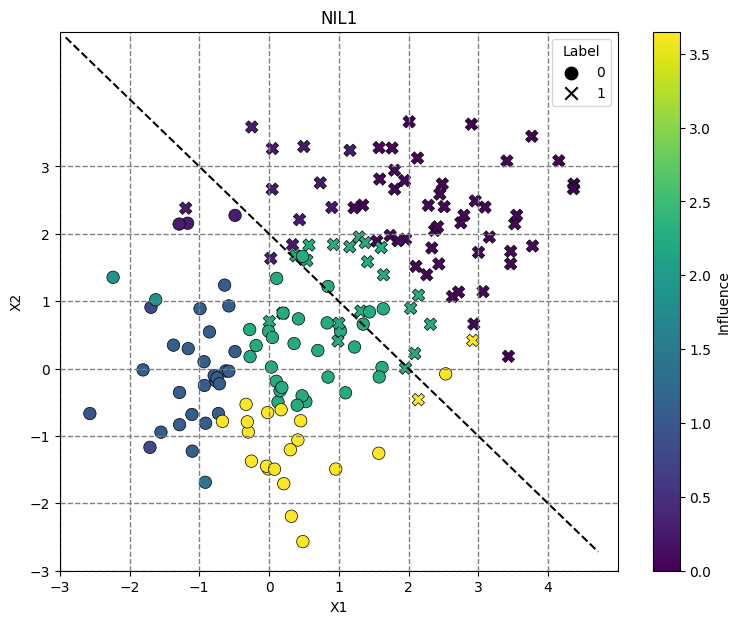

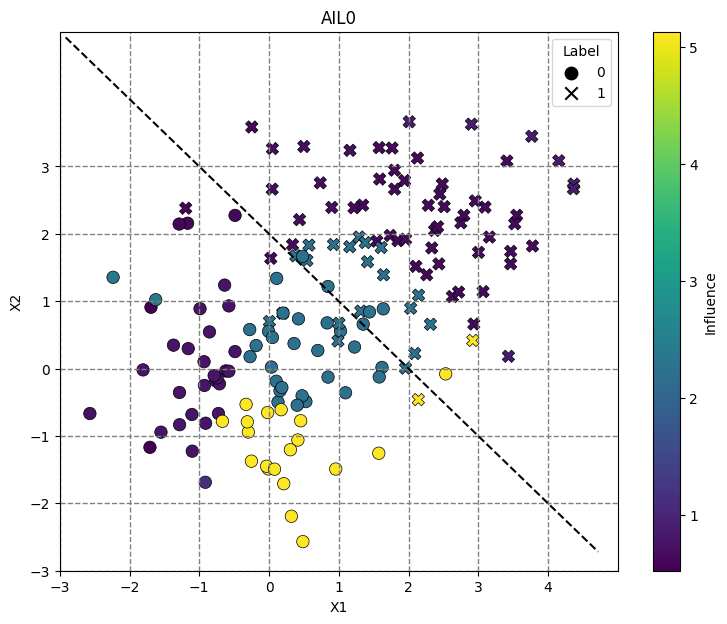

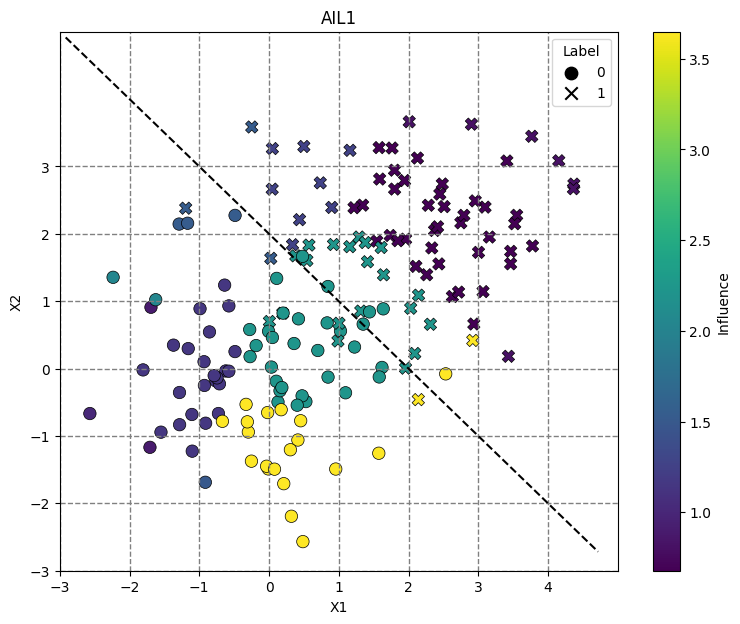

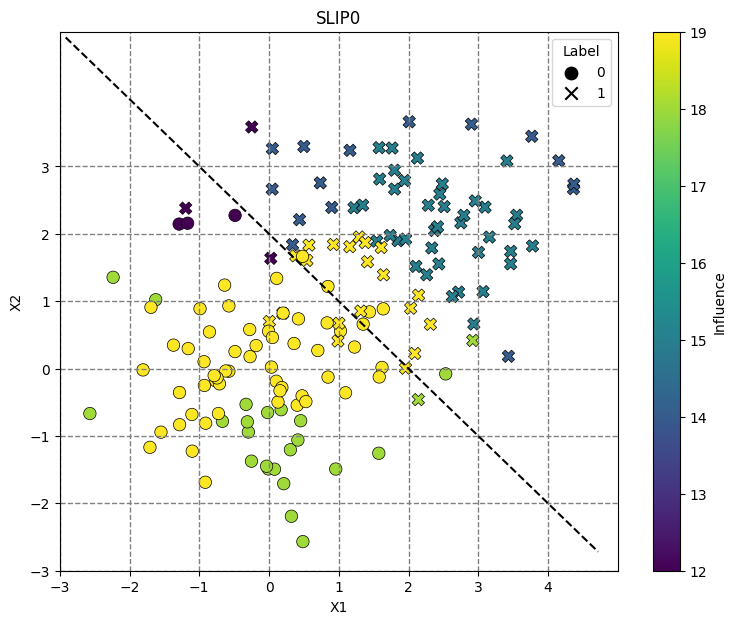

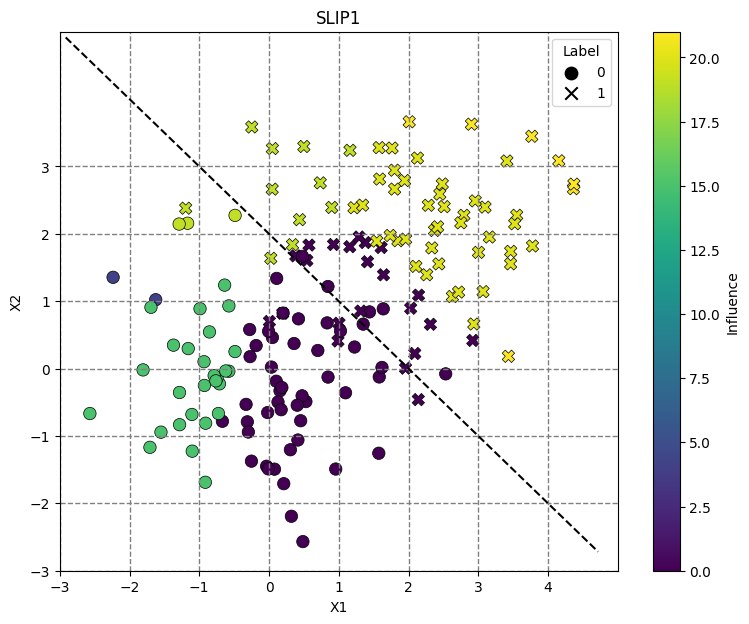

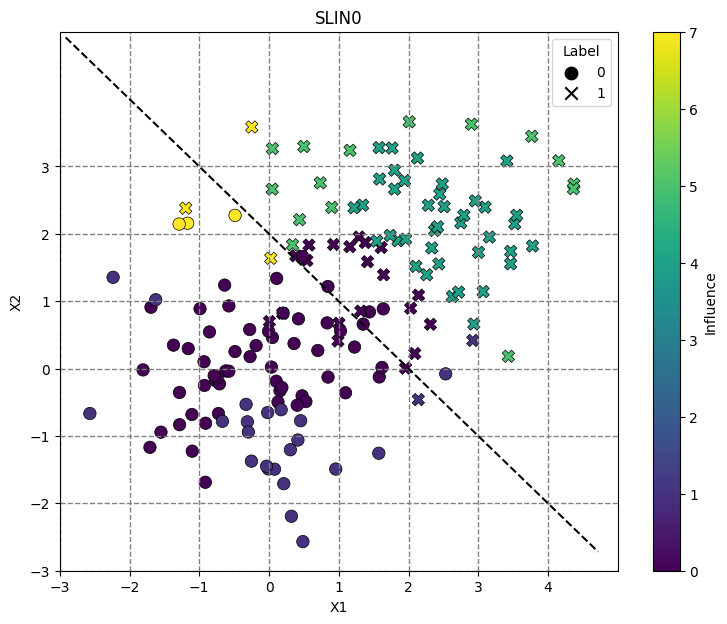

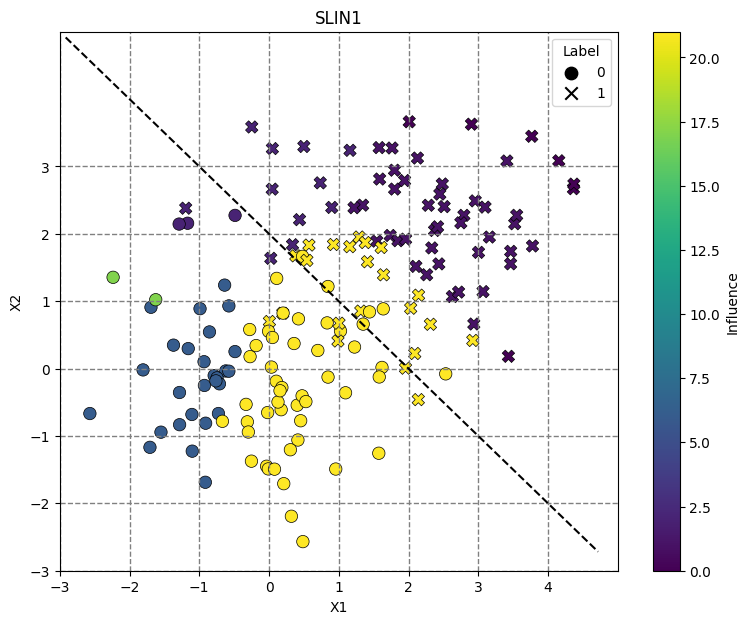

In [17]:

def plot_signal(df, title):
    plt.figure(figsize=(9, 7))
    kwargs = {'edgecolor': "black", 'linewidth': 0.5}
    sp = sns.scatterplot(data=df.sort_values('Influence'), x='X1', y='X2', hue='Influence', legend='brief', style='Label', palette='viridis', s=80, **kwargs,alpha=1)
    sp.get_legend().remove()

    custom_handles = [
        plt.scatter([], [], marker='o', s=80, color='black', label='0'),
        plt.scatter([], [], marker='x', s=80, color='black', label='1'),
    ]

    plt.legend(handles=custom_handles, title='Label')

    norm = plt.Normalize(df['Influence'].min(), df['Influence'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sp.figure.colorbar(sm, ax=sp).set_label('Influence')
    sp.set(title=title)

    x_limits = plt.gca().get_xlim()
    y_limits = plt.gca().get_ylim()

    # Determine the range of x values based on the plot limits
    x = np.linspace(min(x_limits), max(x_limits), 100)

    # Compute the corresponding y values for y = -x
    y = 2-x

    plt.plot(x, y, 'k--')

    x_ticks = np.arange(np.floor(min(x_limits)), np.ceil(max(x_limits)), 1)
    y_ticks = np.arange(np.floor(min(y_limits)), np.ceil(max(y_limits)), 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.grid(True, linewidth=1, linestyle='--', color='gray')


    plt.xlim(-3,5)
    plt.ylim(-3,5)

    plt.show()


def get_inf_graph(matrix):

    indexes = list(set(flatten([eval(x) for x in matrix.index])))
    df = pd.DataFrame(index=indexes, columns=['Influence'])
    for indexes in matrix.index:
        for idx in eval(indexes):
            df.loc[idx]=matrix.loc[indexes]['Influence']
    return df




#PIL0
#PIL1
#NIL0
#NIL1
#AIL0
#AIL1

#SLIP0
#SLIP1
#SLIN0
#SLIP1


plot_signal(get_inf_graph(run_MPI(CONJOINT_50)).join(testdata),  "MPI")
plot_signal(get_inf_graph(run_MNI(CONJOINT_50)).join(testdata),  "MNI")
plot_signal(get_inf_graph(run_MAI(CONJOINT_50)).join(testdata),  "MAI")
plot_signal(get_inf_graph(run_MSPI(CONJOINT_50)).join(testdata), "MSPI")
plot_signal(get_inf_graph(run_MSNI(CONJOINT_50)).join(testdata), "MSNI")


plot_signal(get_inf_graph(run_PIL(testdata,CONJOINT_50,0)).join(testdata), "PIL0")
plot_signal(get_inf_graph(run_PIL(testdata,CONJOINT_50,1)).join(testdata), "PIL1")

plot_signal(get_inf_graph(run_NIL(testdata,CONJOINT_50,0)).join(testdata), "NIL0")
plot_signal(get_inf_graph(run_NIL(testdata,CONJOINT_50,1)).join(testdata), "NIL1")

plot_signal(get_inf_graph(run_AIL(testdata,CONJOINT_50,0)).join(testdata), "AIL0")
plot_signal(get_inf_graph(run_AIL(testdata,CONJOINT_50,1)).join(testdata), "AIL1")

plot_signal(get_inf_graph(run_SLIP(testdata,CONJOINT_50,0)).join(testdata), "SLIP0")
plot_signal(get_inf_graph(run_SLIP(testdata,CONJOINT_50,1)).join(testdata), "SLIP1")

plot_signal(get_inf_graph(run_SLIN(testdata,CONJOINT_50,0)).join(testdata), "SLIN0")
plot_signal(get_inf_graph(run_SLIN(testdata,CONJOINT_50,1)).join(testdata), "SLIN1")





In [18]:
## MARGINAL SIGNALS

SEGREGATED = INDIVIDUAL_INFLUENCE.loc[list(set(flatten([eval(x) for x in CONJOINT_50.index])))]





# plot_signal(run_MPI(SEGREGATED).join(testdata),"MPI")
# plot_signal(run_MNI(SEGREGATED).join(testdata),"MNI")
# plot_signal(run_MAI(SEGREGATED).join(testdata),"MAI")
# plot_signal(run_MSPI(SEGREGATED).join(testdata),"MSPI")
# plot_signal(run_MSNI(SEGREGATED).join(testdata),"MSNI")


# plot_signal(run_PIL(testdata,SEGREGATED,0).join(testdata),"PIL0")
# plot_signal(run_PIL(testdata,SEGREGATED,1).join(testdata),"PIL1")

# plot_signal(run_NIL(testdata,SEGREGATED,0).join(testdata),"NIL0")
# plot_signal(run_NIL(testdata,SEGREGATED,1).join(testdata),"NIL1")


# plot_signal(run_AIL(testdata,SEGREGATED,0).join(testdata),"AIL0")
# plot_signal(run_AIL(testdata,SEGREGATED,1).join(testdata),"AIL1")

# plot_signal(run_SLIP(testdata,SEGREGATED,0).join(testdata),"SLIP0")
# plot_signal(run_SLIP(testdata,SEGREGATED,1).join(testdata),"SLIP1")

# plot_signal(run_SLIN(testdata,SEGREGATED,0).join(testdata),"SLIN0")
# plot_signal(run_SLIN(testdata,SEGREGATED,1).join(testdata),"SLIN1")






(-3.4, 5.4)

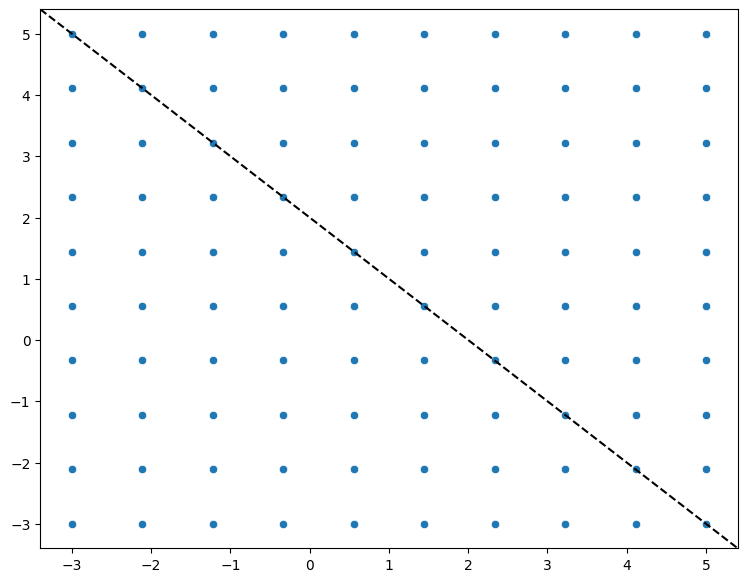

In [19]:
centers_x = np.linspace(-3,5,10)
centers_y = np.linspace(-3,5,10)

points = list(itertools.product(centers_x, centers_y))

plt.figure(figsize=(9, 7))

sns.scatterplot(x = [t[0] for t in points], y= [t[1] for t in points])
x_limits = plt.gca().get_xlim()
y_limits = plt.gca().get_ylim()

# Determine the range of x values based on the plot limits
x = np.linspace(min(x_limits), max(x_limits), 100)

# Compute the corresponding y values for y = -x
y = 2-x

plt.plot(x, y, 'k--')

plt.xlim(x_limits)
plt.ylim(y_limits)

In [20]:
#ktest = get_points_coord(get_neighbors(train, 5, 1,criteria='Given', given_centers = points),train)


def get_points_coord(coord,df):

    center = [x[0] for x in coord]
    points = [x[1] for x in coord]


    all = flatten(points)

    points_df = df.loc[all].copy()


    colors_list = [0,1]
    nueva_lista = [(tupla[0],tupla[1], color) for tupla, color in zip(coord, itertools.cycle(colors_list))]

    values = []
    colors = []
    for item in nueva_lista:
        value_group = item[1]
        color = item[2]
        values.extend(value_group)
        colors.extend([color] * len(value_group))

    # Crear el DataFrame
    color_df = pd.DataFrame({'Color': colors}, index=values)
    points_df['Color'] = color_df['Color']
    return points_df



get_points_coord(get_neighbors(train, 5, 1,criteria='Given', given_centers = points),train)




,X1,X2,Label,Color
56,-1.707211,-1.168489,0.0,0
27,-2.568426,-0.666935,0.0,0
62,-0.913268,-1.687292,0.0,0
31,-1.549260,-0.943586,0.0,0
16,-1.100703,-1.225440,0.0,0
...,...,...,...,...
172,3.766678,3.448052,1.0,1
147,4.154124,3.084533,1.0,1
169,4.370500,2.738545,1.0,1
168,4.363925,2.670286,1.0,1


In [21]:

#ktest = get_points_coord(get_neighbors(train, 5, 1,criteria='Given', given_centers = points),train)


testdata = create_data(5000)


train = testdata.sample(frac=0.8, random_state=1)
test = testdata.drop(train.index)
centers_x = np.linspace(-3,5,21)
centers_y = np.linspace(-3,5,21)
points = list(itertools.product(centers_x, centers_y))
selected = get_points_coord(get_neighbors(train,10, 1,criteria='Given', given_centers = points),train)


def create_scatter_plot(df):
    plt.figure(figsize=(8, 7))
    sp = sns.scatterplot(data=df, x='X1', y='X2', hue='Color', style='Label', s=50, linewidth=0, palette='magma')
    x_limits = plt.gca().get_xlim()
    y_limits = plt.gca().get_ylim()

    # Determine the range of x values based on the plot limits
    x = np.linspace(min(x_limits), max(x_limits), 100)
    # Compute the corresponding y values for y = -x
    y = 2 - x
    plt.plot(x, y, 'k--')


    plt.title("knearest groups")

    x_ticks = np.arange(np.floor(min(x_limits)), np.ceil(max(x_limits)), 1)
    y_ticks = np.arange(np.floor(min(y_limits)), np.ceil(max(y_limits)), 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.grid(True, linewidth=1, linestyle='--', color='gray')

    sp.get_legend().remove()

    custom_handles = [
        plt.scatter([], [], marker='o', s=80, color='black', label='0'),
        plt.scatter([], [], marker='x', s=80, color='black', label='1'),
    ]

    plt.legend(handles=custom_handles, title='Label')
    plt.xlim((-3,5))
    plt.ylim((-3,5))
    return sp



In [22]:
AGM = area_group_matrix(train,test,[x[1] for x in get_neighbors(train,20, 1,criteria='Given', given_centers = points)])

100%|██████████| 441/441 [00:36<00:00, 11.98it/s]


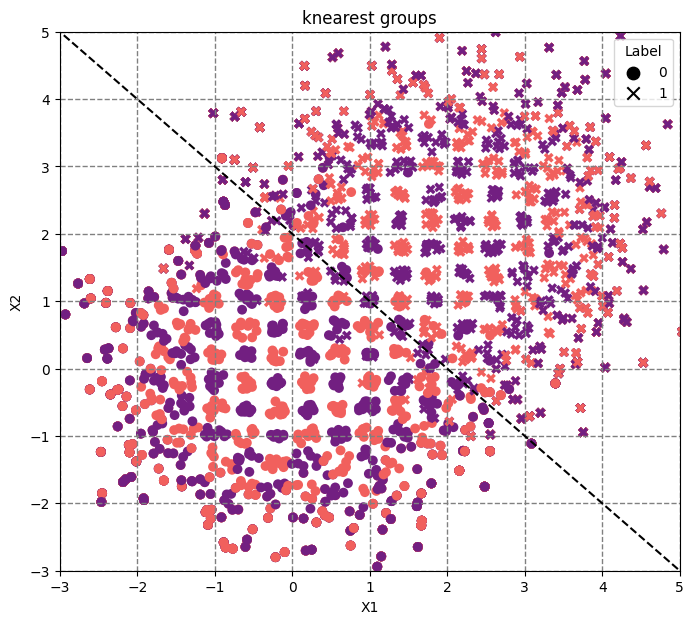

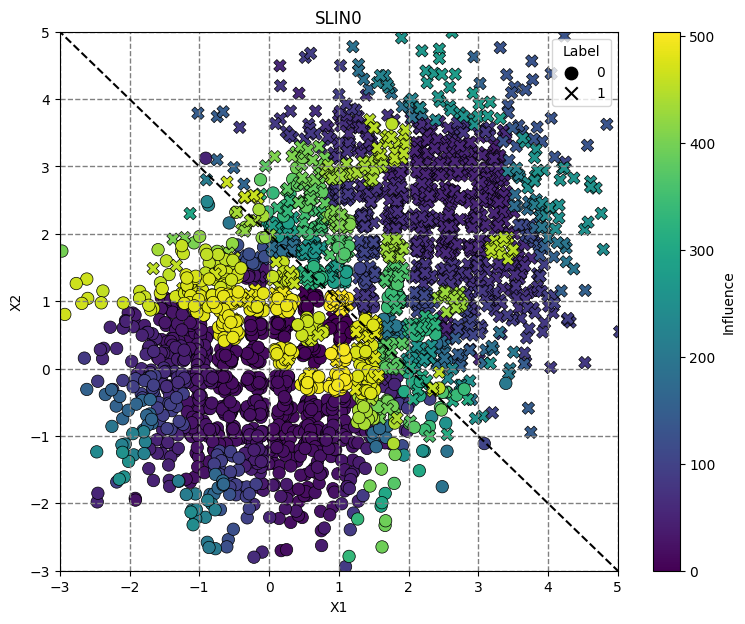

In [23]:

create_scatter_plot(selected)
plot_signal(get_inf_graph(run_SLIN(testdata,AGM,0)).join(testdata), "SLIN0")

In [24]:
 my_list = list(AGM.index)

def check_list(arg):
    for i in arg:
        if arg.count(i) > 1:
            return 'Duplicate'

print(check_list(my_list) == 'Duplicate')

False
